In [1]:
import numpy as np
import pandas as pd
import scipy

from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# На основе того же набора данных требуется
 
1. Построить предсказательные интервалы для ежемесячного дохода и запрошенной суммы (в предположении логнормальности)
2. Определить для каждого признака, разделяет ли он риски. Т.е. надо строить доверительные интервалы для **approved_flg** по каждому признаку. *Подсказка:* для бинарных признаков можно строить интервалы на разность долей, для вещественных признаков - используйте разбивки на бакеты (группы равного размера) и сравнивайте полученные интервалы между этими группами. Попробуйте визуализировать результаты (для вещественных признаков).
3. Введите бинарный признак (какая сумма больше - запрошенная или ежемесячная зарплата) - оцените точечно и интервально шансы (odds) одобрения в зависимости от этого признака $$\text{odds: } \frac{p}{1-p}$$ Постройте также интервал для отношения шансов на этих выборках. *Подсказка:* используйте бутстреп.
 

In [2]:
df = pd.read_csv('data.csv', sep=',')

In [3]:
df.head()

,id,required_amt,installment_flg,monthly_income_amt,age,has_high_education_flg,approved_flg
0,1,23906.0,0,80000,37,0,0
1,2,13111.0,1,43000,22,0,0
2,3,43266.0,1,20000,34,0,0
3,4,68782.0,1,35000,24,0,0
4,5,19550.0,1,25000,42,1,0


* id - идентификатор заявки на получение кредита на товар/услугу
* required_amt - запрошенная сумма кредита
* installment_flg - флаг промо продукта
* monthly_income_amt - ежемесячный доход заявителя
* age - возраст заявителя
* has_high_education_flg - наличие высшего образования
* approved_flg - одобрил ли банк заявку

# 1 пункт

In [4]:
required_amt_norm=np.log(df.required_amt)
monthly_income_amt_norm=np.log(df.monthly_income_amt)


In [5]:
monthly_income_conf_int = _tconfint_generic(monthly_income_amt_norm.mean(),
                                            monthly_income_amt_norm.std(ddof=1),
                                            len(df) - 1,
                                            0.01,
                                            'two-sided')
required_conf_int = _tconfint_generic(required_amt_norm.mean(),
                                      required_amt_norm.std(ddof=1),
                                      len(df) - 1,
                                      0.01,
                                      'two-sided')

print(f'monthly_income_amt 99% Prediction interval: [{np.exp(monthly_income_conf_int)[0]:,.2f} - {np.exp(monthly_income_conf_int)[1]:,.2f}]')
print(f'required_amt 99% Prediction interval: [{np.exp(required_conf_int)[0]:,.2f} - {np.exp(required_conf_int)[1]:,.2f}]')

monthly_income_amt 99% Prediction interval: [9,174.69 - 169,934.87]
required_amt 99% Prediction interval: [4,214.31 - 197,612.36]


# 2 пункт
### Бинарные признаки

In [6]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в независимых выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    sigma = np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    left_boundary = (p1 - p2) - z * sigma
    right_boundary = (p1 - p2) + z * sigma
    return (left_boundary, right_boundary)
def proportions_confint_diff_rel(sample1, sample2, alpha = 0.01):
    '''Считает доверительный интервал для разности долей в связных выборках'''
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    n = len(sample1)
    a_10 = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in zip(sample1, sample2)])
    a_01 = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in zip(sample1, sample2)])
    sigma = np.sqrt(float((a_10 + a_01)) / n ** 2 - float((a_10 - a_01) ** 2) / n ** 3)
    left_boundary = float(a_10 - a_01) / n  - z * sigma
    right_boundary = float(a_10 - a_01) / n  + z * sigma
    return (left_boundary, right_boundary)

In [7]:
client_has_education_conf_int = proportion_confint(df[df.has_high_education_flg==1].approved_flg.sum(),
                                                    len(df[df.has_high_education_flg==1].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
client_hasnt_education_conf_int = proportion_confint(df[df.has_high_education_flg==0].approved_flg.sum(),
                                                    len(df[df.has_high_education_flg==0].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'client has high education 99% confidence interval: [{client_has_education_conf_int[0]:.3f} - {client_has_education_conf_int[1]:.3f}]')
print(f"client hasn't high education 99% confidence interval: [{client_hasnt_education_conf_int[0]:.3f} - {client_hasnt_education_conf_int[1]:.3f}]")

client has high education 99% confidence interval: [0.307 - 0.348]
client hasn't high education 99% confidence interval: [0.212 - 0.239]


Интервалы не пересекаются => наличие образования влияет на одоброение

In [61]:
client_has_installment_conf_int = proportion_confint(df[df.installment_flg==1].approved_flg.sum(),
                                                    len(df[df.installment_flg==1].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')
client_hasnt_installment_conf_int = proportion_confint(df[df.installment_flg==0].approved_flg.sum(),
                                                    len(df[df.installment_flg==0].approved_flg),
                                                    alpha = 0.01,
                                                    method = 'wilson')

print(f'client has installment  99% confidence interval: [{client_has_installment_conf_int[0]:.3f} - {client_has_installment_conf_int[1]:.3f}]')
print(f"client hasn't installment 99% confidence interval: [{client_hasnt_installment_conf_int[0]:.3f} - {client_hasnt_installment_conf_int[1]:.3f}]")

client has installment  99% confidence interval: [0.247 - 0.275]
client hasn't installment 99% confidence interval: [0.244 - 0.281]


Интервалы пересекаются, исследуем дальше

In [62]:
proportions_confint_diff_ind(df[df.installment_flg==1].approved_flg,
                             df[df.installment_flg==0].approved_flg)

(-0.02488224598127247, 0.021904336839108467)

Лежит по разные стороны от 0, не стат значимо.

### Вещественные признаки
### Возраст

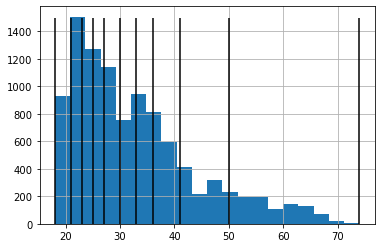

In [65]:
df['age'].hist(bins=20)
vlines(np.percentile(df.age,0),0,1500)
vlines(np.percentile(df.age,10),0,1500)
vlines(np.percentile(df.age,20),0,1500)
vlines(np.percentile(df.age,30),0,1500)
vlines(np.percentile(df.age,40),0,1500)
vlines(np.percentile(df.age,50),0,1500)
vlines(np.percentile(df.age,60),0,1500)
vlines(np.percentile(df.age,70),0,1500)
vlines(np.percentile(df.age,80),0,1500)
vlines(np.percentile(df.age,90),0,1500)
vlines(np.percentile(df.age,100),0,1500)




 18.0-21.0 yaers client 99% confidence interval: [0.040 - 0.085]
 21.0-23.0 yaers client 99% confidence interval: [0.100 - 0.179]
 23.0-25.0 yaers client 99% confidence interval: [0.142 - 0.236]
 25.0-27.0 yaers client 99% confidence interval: [0.165 - 0.271]
 27.0-30.0 yaers client 99% confidence interval: [0.214 - 0.294]
 30.0-33.0 yaers client 99% confidence interval: [0.282 - 0.372]
 33.0-36.0 yaers client 99% confidence interval: [0.243 - 0.341]
 36.0-41.0 yaers client 99% confidence interval: [0.296 - 0.379]
 41.0-50.0 yaers client 99% confidence interval: [0.355 - 0.440]
 50.0-74.0 yaers client 99% confidence interval: [0.387 - 0.470]


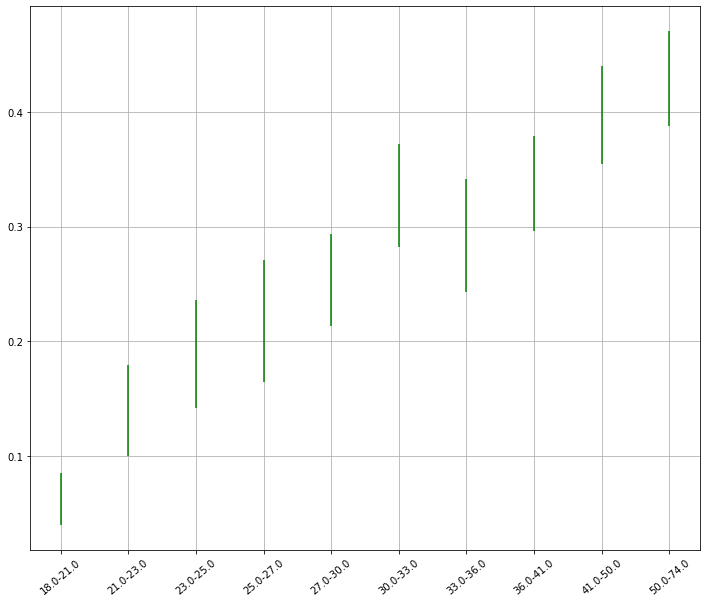

In [78]:
approved=[]

for i in range(10):
    mylist = [0,10,20,30,40,50,60,70,80,90,100]
    buckets = df[(df.age > np.percentile(df.age,mylist[i])) & (df.age < np.percentile(df.age,mylist[i+1]))].approved_flg
    approved_client_conf_int = proportion_confint(buckets.sum(),
                                                 len(buckets),
                                                 alpha = 0.01,
                                                 method = 'wilson')
    approved.append(approved_client_conf_int)
    print(f' {np.percentile(df.age,mylist[i])}-{np.percentile(df.age,mylist[i+1])} yaers client 99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')
pylab.figure(figsize=(12, 10))
pylab.grid()
x=[]
for i in range(10):
    pylab.vlines(x=i, ymin=approved[i][0], ymax=approved[i][1], color='green')
    x.append(f'{np.percentile(df.age,mylist[i])}-{np.percentile(df.age,mylist[i+1])}')
    xticks(np.arange(10), (x), rotation=40)


### Запрошенная сумма

 0-10 percentile client 99% confidence interval: [0.304 - 0.381]
 10-20 percentile client 99% confidence interval: [0.321 - 0.399]
 20-30 percentile client 99% confidence interval: [0.266 - 0.341]
 30-40 percentile client 99% confidence interval: [0.252 - 0.325]
 40-50 percentile client 99% confidence interval: [0.256 - 0.330]
 50-60 percentile client 99% confidence interval: [0.261 - 0.335]
 60-70 percentile client 99% confidence interval: [0.213 - 0.283]
 70-80 percentile client 99% confidence interval: [0.148 - 0.210]
 80-90 percentile client 99% confidence interval: [0.141 - 0.202]
 90-100 percentile client 99% confidence interval: [0.113 - 0.170]


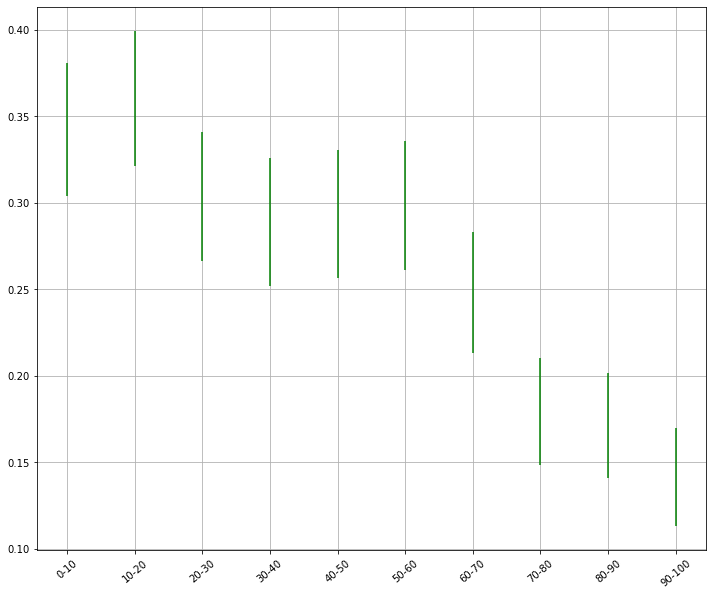

In [155]:
approved=[]

for i in range(10):
    mylist = [0,10,20,30,40,50,60,70,80,90,100] 
    buckets = df[(df.required_amt > np.percentile(df['required_amt'].dropna().astype(int64),mylist[i])) & (df.required_amt <  np.percentile(df['required_amt'].dropna().astype(int64),mylist[i+1]))].approved_flg
    approved_client_conf_int = proportion_confint(buckets.sum(),
                                                 len(buckets),
                                                 alpha = 0.01,
                                                 method = 'wilson')
    approved.append(approved_client_conf_int)
    print(f' {mylist[i]}-{mylist[i+1]} percentile client 99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')
pylab.figure(figsize=(12, 10))
pylab.grid()
x=[]
for i in range(10):
    pylab.vlines(x=i, ymin=approved[i][0], ymax=approved[i][1], color='green')
    x.append(f'{mylist[i]}-{mylist[i+1]}')
    xticks(np.arange(10), (x), rotation=40)

### Ежемесячный доход

 22.0-20000.0 rub client 99% confidence interval: [0.255 - 0.347]
 20000.0-25000.0 rub client 99% confidence interval: [0.181 - 0.308]
 25000.0-30000.0 rub client 99% confidence interval: [0.167 - 0.266]
 30000.0-35000.0 rub client 99% confidence interval: [0.156 - 0.278]
 35000.0-40000.0 rub client 99% confidence interval: [0.198 - 0.333]
 40000.0-45000.0 rub client 99% confidence interval: [0.147 - 0.300]
 45000.0-50000.0 rub client 99% confidence interval: [0.128 - 0.279]
 50000.0-60000.0 rub client 99% confidence interval: [0.153 - 0.250]
 60000.0-80000.0 rub client 99% confidence interval: [0.218 - 0.302]
 80000.0-1500000.0 rub client 99% confidence interval: [0.240 - 0.320]


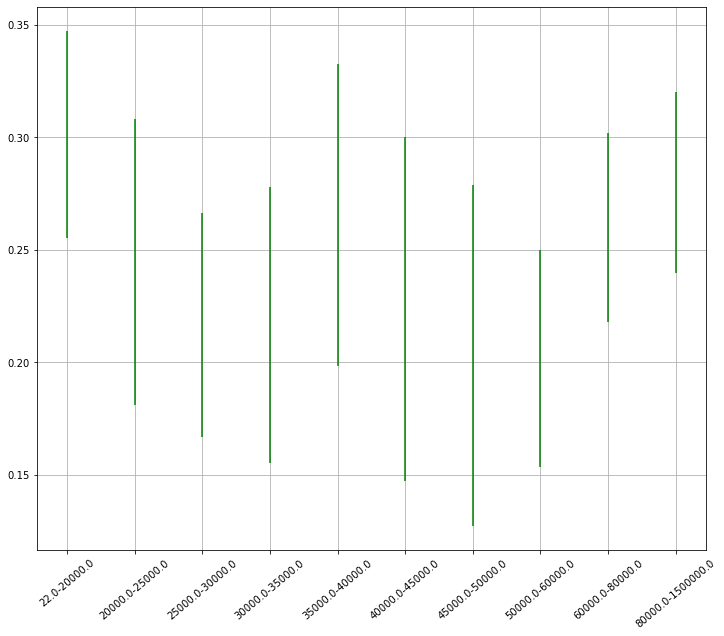

In [160]:
approved=[]

for i in range(10):
    mylist = [0,10,20,30,40,50,60,70,80,90,100]  
    buckets = df[(df.monthly_income_amt > np.percentile(df.monthly_income_amt,mylist[i])) & (df.monthly_income_amt < np.percentile(df.monthly_income_amt,mylist[i+1]))].approved_flg
    approved_client_conf_int = proportion_confint(buckets.sum(),
                                                 len(buckets),
                                                 alpha = 0.01,
                                                 method = 'wilson')
    approved.append(approved_client_conf_int)
    print(f' {np.percentile(df.monthly_income_amt,mylist[i])}-{np.percentile(df.monthly_income_amt,mylist[i+1])} rub client 99% confidence interval: [{approved_client_conf_int[0]:.3f} - {approved_client_conf_int[1]:.3f}]')
pylab.figure(figsize=(12, 10))
pylab.grid()
x=[]
for i in range(10):
    pylab.vlines(x=i, ymin=approved[i][0], ymax=approved[i][1], color='green')
    x.append(f'{np.percentile(df.monthly_income_amt,mylist[i])}-{np.percentile(df.monthly_income_amt,mylist[i+1])}')
    xticks(np.arange(10), (x), rotation=40)

# 3 пункт

# На основе того же набора данных требуется
 
1. Построить предсказательные интервалы для ежемесячного дохода и запрошенной суммы (в предположении логнормальности)
2. Определить для каждого признака, разделяет ли он риски. Т.е. надо строить доверительные интервалы для **approved_flg** по каждому признаку. *Подсказка:* для бинарных признаков можно строить интервалы на разность долей, для вещественных признаков - используйте разбивки на бакеты (группы равного размера) и сравнивайте полученные интервалы между этими группами. Попробуйте визуализировать результаты (для вещественных признаков).
3. Введите бинарный признак (какая сумма больше - запрошенная или ежемесячная зарплата) - оцените точечно и интервально шансы (odds) одобрения в зависимости от этого признака $$\text{odds: } \frac{p}{1-p}$$ Постройте также интервал для отношения шансов на этих выборках. *Подсказка:* используйте бутстреп.
 

In [67]:
new = []
for i in range(len(df)):
    if df.required_amt[i] > df.monthly_income_amt[i]:
        new.append(1)
    else:
        new.append(0)
df['new']=new

# Точечные оценки

### odds-одобренных

In [68]:
p_approved = df[df.new == 1].approved_flg.sum()/len(df[df.new == 1].approved_flg)
odds_approved = p_approved/(1-p_approved)
odds_approved

0.21964285714285714

### odds-отказанных

In [87]:
p_rejected = df[df.new == 0].approved_flg.sum()/len(df[df.new == 0].approved_flg)
odds_rejected = p_rejected/(1-p_rejected)
odds_rejected

0.4349531488341687

In [88]:
def get_bootstrap_samples(data, n_samples):
    np.random.seed(0)
    '''Генерирует заданное кол-во (n_samples) выборок, равных по размеру исходной выборке'''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def get_stat_intervals(stat, alpha):
    np.random.seed(0)
    '''Для заданной выборки возвращает двусторонний доверительный интервал [aplpha/2, 1 - alpha/2]'''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

### Интервальная оценка с помощью бутстрепа

In [89]:

approved = get_bootstrap_samples(df[df.new == 1].approved_flg.values, 1000)
rejected = get_bootstrap_samples(df[df.new == 0].approved_flg.values, 1000)
def odds(data):
    boots = []
    for i in range(len(data)):
        p = (sum(data[i])/len(data[i]))
        boots.append(p/(1-p))
        
    return boots

approved_odds_scores = odds(approved)
rejected_odds_scores = odds(rejected)
print('approved client 99% confidence interval:',  get_stat_intervals(approved_odds_scores, 0.01))
print('rejected client 99% confidence interval:',  get_stat_intervals(rejected_odds_scores, 0.01))   

approved client 99% confidence interval: [0.19698353 0.24453807]
rejected client 99% confidence interval: [0.40704377 0.46921017]


Видно, что наши точечные оценки входят в интевральные

In [90]:
diff_odds_scores = list(map(lambda x: x[1]/x[0], zip(approved_odds_scores, rejected_odds_scores)))
print(f'Среднее отношение в шансах: {sum(diff_odds_scores) / len(diff_odds_scores) :.2f}')

Среднее отношение в шансах: 1.98


In [91]:
print('99% confidence interval for the ratio between odds',  get_stat_intervals(diff_odds_scores, 0.01))

99% confidence interval for the ratio between odds [1.70047984 2.27216691]
